In [1]:
# Here I do the git clone of two repositories, the first one contains the G-CNN 
# experiment and the second one is my personal repository for this project
!git clone https://github.com/adambielski/GrouPy.git
!git clone https://github.com/dstanco98/DeepLearningProject.git

Cloning into 'GrouPy'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 167 (delta 35), reused 33 (delta 33), pack-reused 119
Receiving objects: 100% (167/167), 141.59 KiB | 5.66 MiB/s, done.
Resolving deltas: 100% (75/75), done.
Cloning into 'DeepLearningProject'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 53 (delta 5), reused 32 (delta 0), pack-reused 4
Unpacking objects: 100% (53/53), 80.16 MiB | 9.23 MiB/s, done.


In [2]:
%cd GrouPy/
!python setup.py install
%cd ..

/kaggle/working/GrouPy
running install
running build
running build_py
creating build
creating build/lib
creating build/lib/groupy
copying groupy/__init__.py -> build/lib/groupy
creating build/lib/groupy/garray
copying groupy/garray/p4_array.py -> build/lib/groupy/garray
copying groupy/garray/C4_array.py -> build/lib/groupy/garray
copying groupy/garray/garray.py -> build/lib/groupy/garray
copying groupy/garray/p4m_array.py -> build/lib/groupy/garray
copying groupy/garray/finitegroup.py -> build/lib/groupy/garray
copying groupy/garray/__init__.py -> build/lib/groupy/garray
copying groupy/garray/matrix_garray.py -> build/lib/groupy/garray
copying groupy/garray/Z2_array.py -> build/lib/groupy/garray
copying groupy/garray/D4_array.py -> build/lib/groupy/garray
copying groupy/garray/test_garray.py -> build/lib/groupy/garray
creating build/lib/groupy/gconv
copying groupy/gconv/__init__.py -> build/lib/groupy/gconv
copying groupy/gconv/make_gconv_indices.py -> build/lib/groupy/gconv
creating b

In [3]:
# Here we have some useful imports for the train
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from torch.optim.lr_scheduler import MultiStepLR
import torch.backends.cudnn as cudnn

In [4]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Here we download the CIFAR10 dataset (trainset and testset)
trainset = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified



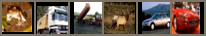

Ground truth: ['frog', 'truck', 'truck', 'deer', 'car', 'car']


In [5]:
# Useful function to visualize samples

def visualize_samples(inputs, title=None):
    """
    Visualization of transformed samples, a standard call:
        inputs, classes = next(iter(dataloaders['train']))
        visualize_samples(inputs)
    Arguments:
    batch_of_samples -- a batch from the dataloader; a PyTorch tensor of shape (batch_size, 3, 224, 224)

    Return:
    None (A nice plot)
    """
    
    # Make a grid from batch
    inp = utils.make_grid(inputs, nrow=12)

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)  # plotly accepts the colour information both in the 0-1 range and in the 0-255 range
    fig = px.imshow(inp, title=title)
    fig.show()


# Get a batch of training data
inputs = [trainset[i][0] for i in range(6)]
class_idx = [trainset[i][1] for i in range(6)]


visualize_samples(inputs, title=f'Make your prediction, which is the label of each image? The labels are<br> {[x for x in classes]}')  

# Solution
print(f'Ground truth: {[classes[x] for x in class_idx]}')

In [7]:
# Useful import for using G-CNN
from groupy.gconv.pytorch_gconv.splitgconv2d import P4MConvZ2, P4MConvP4M

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = P4MConvP4M(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = P4MConvP4M(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                P4MConvP4M(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = P4MConvP4M(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = P4MConvP4M(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = P4MConvP4M(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                P4MConvP4M(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 23

        self.conv1 = P4MConvZ2(3, 23, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(23)
        self.layer1 = self._make_layer(block, 23, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 45, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 91, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 181, num_blocks[3], stride=2)
        self.linear = nn.Linear(181*8*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        outs = out.size()
        out = out.view(outs[0], outs[1]*outs[2], outs[3], outs[4])
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

In [8]:
# We want to print the training loss every log_freq batches
log_freq = len(trainset)//128  # default 

def train(epoch, net, optimizer, loss_func, log_freq=log_freq):
    running_loss = 0.0
    for i, data in enumerate(trainloader, start=1):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i) % log_freq == 0:    # print every log_freq mini-batches
            print('[Epoch : %d, Iter: %5d] loss: %.3f' %
                  (epoch + 1, i, running_loss / log_freq))
            running_loss = 0.0
    return running_loss / log_freq

def test(net, train_data=False):
    if train_data:
        print("Accuracy on training data")
        dataloader = trainloader
    else:
        print("Accuracy on test data")
        dataloader = testloader
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader):
            if batch_idx == len(testloader):
                break
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            output = net(inputs)
            _, predicted = torch.max(output, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %.2f %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

    test_score = np.mean([100 * class_correct[i] / class_total[i] for i in range(10)])
    print(test_score)
    return test_score

In the cell below the model train is done, the numer of epochs is equal to 140, that represents a good threshold in order to obtain nice results
The entire training take almost **10 hours** and I decided to use the accelerator GPU P100.


In [8]:
from tqdm.notebook import tqdm

run_training = True  #@param {type:"boolean"}
SAVE_PATH = "./data/" #@param
epoch_num = 140
PATH = SAVE_PATH + 'ckpt.pt'
test_freq = 10
resume = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

if run_training:
    net = ResNet18()
    learning_rate = 0.05
    momentum = 0.9
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum,
                            weight_decay=5e-4)
    
    start_epoch = 0
    
    if device == 'cuda':
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = True
    net.to(device)
    milestones = [50, 100, 140]
    scheduler = MultiStepLR(optimizer, milestones, gamma=0.1)
        
    for idx in tqdm(range(start_epoch, start_epoch + epoch_num)):
        net.train()
        loss = train(idx, net, optimizer, criterion)
        scheduler.step()

        if (idx+1) % test_freq == 0:
            print('\n-------------Network Test-------------')
            net.eval()
            test(net)
            test(net, train_data=True)
            print('----------------------------------------\n')
        torch.save({
              'epoch': idx,
              'model_state_dict': net.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss,
          }, PATH)

cuda:0


  0%|          | 0/140 [00:00<?, ?it/s]

[Epoch : 1, Iter:   390] loss: 2.060
[Epoch : 2, Iter:   390] loss: 1.635
[Epoch : 3, Iter:   390] loss: 1.332
[Epoch : 4, Iter:   390] loss: 1.065
[Epoch : 5, Iter:   390] loss: 0.793
[Epoch : 6, Iter:   390] loss: 0.622
[Epoch : 7, Iter:   390] loss: 0.514
[Epoch : 8, Iter:   390] loss: 0.443
[Epoch : 9, Iter:   390] loss: 0.387
[Epoch : 10, Iter:   390] loss: 0.336

-------------Network Test-------------
Accuracy on test data
Accuracy of plane : 93.80 %
Accuracy of   car : 90.90 %
Accuracy of  bird : 84.70 %
Accuracy of   cat : 77.30 %
Accuracy of  deer : 75.00 %
Accuracy of   dog : 79.00 %
Accuracy of  frog : 82.50 %
Accuracy of horse : 87.20 %
Accuracy of  ship : 92.00 %
Accuracy of truck : 87.70 %
85.01
Accuracy on training data
Accuracy of plane : 96.37 %
Accuracy of   car : 93.85 %
Accuracy of  bird : 87.91 %
Accuracy of   cat : 84.99 %
Accuracy of  deer : 77.57 %
Accuracy of   dog : 83.10 %
Accuracy of  frog : 82.54 %
Accuracy of horse : 89.01 %
Accuracy of  ship : 91.83 %
Acc

Since loading the data contained in the Kaggle output folders takes a very long time to load, I decided to zip the whole folder so that it could be downloaded.

In [9]:
!zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/GrouPy/ (stored 0%)
  adding: kaggle/working/GrouPy/.gitignore (deflated 49%)
  adding: kaggle/working/GrouPy/p4m_fmaps.png (deflated 3%)
  adding: kaggle/working/GrouPy/setup.py (deflated 48%)
  adding: kaggle/working/GrouPy/p4_fmaps.png (deflated 1%)
  adding: kaggle/working/GrouPy/LICENSE (deflated 40%)
  adding: kaggle/working/GrouPy/.git/ (stored 0%)
  adding: kaggle/working/GrouPy/.git/branches/ (stored 0%)
  adding: kaggle/working/GrouPy/.git/info/ (stored 0%)
  adding: kaggle/working/GrouPy/.git/info/exclude (deflated 28%)
  adding: kaggle/working/GrouPy/.git/logs/ (stored 0%)
  adding: kaggle/working/GrouPy/.git/logs/refs/ (stored 0%)
  adding: kaggle/working/GrouPy/.git/logs/refs/remotes/ (stored 0%)
  adding: kaggle/working/GrouPy/.git/logs/refs/remotes/origin/ (stored 0%)
  adding: kaggle/working/GrouPy/.git/logs/refs/remotes/origin/HEAD (deflated 27%)
  a